In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

for dirname, _, filenames in os.walk("./"):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./all_emails.csv
./Project_4.ipynb
./.ipynb_checkpoints/all_emails-checkpoint.csv
./.ipynb_checkpoints/Project_4-checkpoint.ipynb
./og_emails/6-14msg3.txt
./og_emails/6-110msg1.txt
./og_emails/9-63msg1.txt
./og_emails/spmsga95.txt
./og_emails/6-97msg1.txt
./og_emails/8-887msg1.txt
./og_emails/spmsgb16.txt
./og_emails/6-830msg1.txt
./og_emails/9-612msg1.txt
./og_emails/spmsga161.txt
./og_emails/spmsgc135.txt
./og_emails/6-113msg2.txt
./og_emails/6-829msg3.txt
./og_emails/spmsga130.txt
./og_emails/spmsgc119.txt
./og_emails/spmsga65.txt
./og_emails/3-390msg0.txt
./og_emails/3-389msg1.txt
./og_emails/spmsgc133.txt
./og_emails/5-1318msg2.txt
./og_emails/spmsgb77.txt
./og_emails/spmsgc68.txt
./og_emails/3-378msg5.txt
./og_emails/8-840msg1.txt
./og_emails/6-1msg1.txt
./og_emails/6-68msg1.txt
./og_emails/5-1315msg2.txt
./og_emails/spmsgc37.txt
./og_emails/6-455msg1.txt
./og_emails/6-50msg0.txt
./og_emails/spmsgc74.txt
./og_emails/6-425msg3.txt
./og_emails/6-55msg1.txt
./og_emails/spmsgb3.txt
.

In [25]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import pandas as pd
from scipy import stats
from wordcloud import WordCloud, STOPWORDS
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# 1. Frame the problem
Using the customer description, Define the problem your trying to solve in your own words (remember this is not technial but must be specific so the customer understands the project

Given the pre-processed emails that are classified as either spam or ham, create a machine learning system trained on this dataset of emails that can effectively predict whether or not an email is spam or ham.

# 2. Get the Data 
Define how you recieved the data (provided, gathered..)

In [3]:
dir_name = './og_emails'

all_emails = pd.DataFrame(columns=['subject', 'contents', 'subj_len', 'body_len', 'is_spam']) # initialize df with col names

# iterate through each .txt file 
for filename in os.listdir(dir_name):
    path = os.path.join(dir_name, filename)
    if os.path.isfile(path):
        with open(path, 'r') as file:
            contents = file.read() 
            text_list = contents.split('\n')
            text_list = [x for x in text_list if x]

        # extract subject line and email content 
        subj_line = text_list[0][9:] 
        email_cont = text_list[1] 
        is_spam = 1 if 'spm' in filename else 0
        
        all_emails.loc[len(all_emails)] = [subj_line, email_cont, len(subj_line), len(email_cont), is_spam]

all_emails.to_csv('all_emails.csv', index=False) # create into csv for visualization 

In [4]:
all_emails.head()

,subject,contents,subj_len,body_len,is_spam
0,wkshp : * early * - e ( = ) uralic interaction,organize combination colloquium work seminar p...,46,1917,0
1,job announcement - academium sinica,"job announcement institute history philology ,...",35,1339,0
2,knowledge language bibliography,association language awareness knowledge langu...,31,953,0
3,service update,due significant rapid policy change recently i...,14,311,1
4,job announcement,job announcement department foreign language l...,16,1218,0


# 3. Explore the Data
Gain insights into the data you have from step 2, making sure to identify any bias

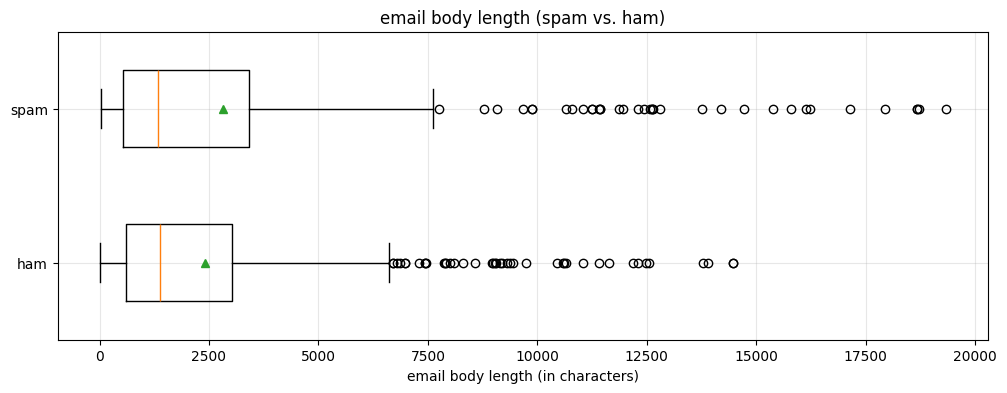

In [5]:
# analyze lengths of spam vs. ham emails (chars) 

spam_lens = all_emails[all_emails['is_spam'] == 1]['body_len']
ham_lens = all_emails[all_emails['is_spam'] == 0]['body_len'] 

plt.figure(figsize=(12, 4))
plt.boxplot([ham_lens, spam_lens], tick_labels=['ham', 'spam'], widths=.5, vert=False, showmeans=True)
plt.xlabel('email body length (in characters)')
plt.title('email body length (spam vs. ham)')
plt.grid(True, alpha=0.3)
plt.show()

# observations:
# roughly equal median, both have many outliers 
# but only spam emails have body lengths > 150000 
# which can be a good feature to add! 

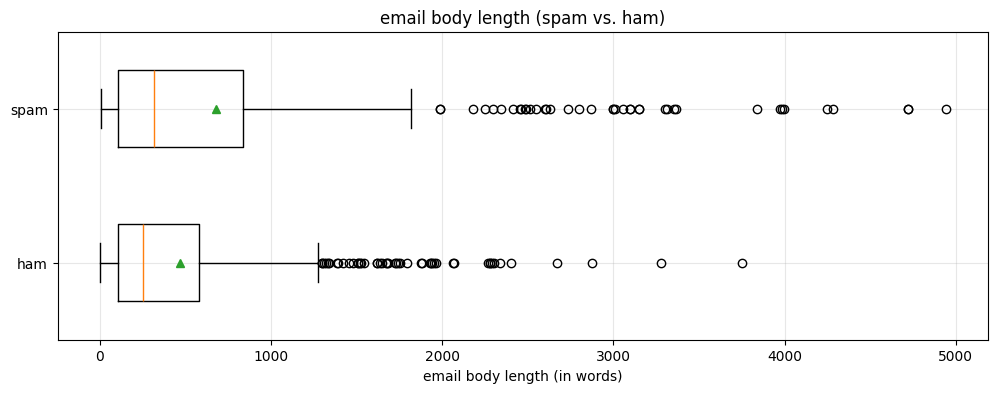

In [6]:
# analyze word count instead of char count

all_emails['word_count'] = all_emails['contents'].apply(lambda x: len(x.split()))

spam_wc = all_emails[all_emails['is_spam'] == 1]['word_count']
ham_wc = all_emails[all_emails['is_spam'] == 0]['word_count']

plt.figure(figsize=(12, 4))
plt.boxplot([ham_wc, spam_wc], tick_labels=['ham', 'spam'], widths=.5, vert=False, showmeans=True)
plt.xlabel('email body length (in words)')
plt.title('email body length (spam vs. ham)')
plt.grid(True, alpha=0.3)
plt.show()

# on average, it seems as if spam has a much greater q3-q4 range 
# and also only spam emails have word counts > 4000 
# it also seems as if there is a clustering of outliers

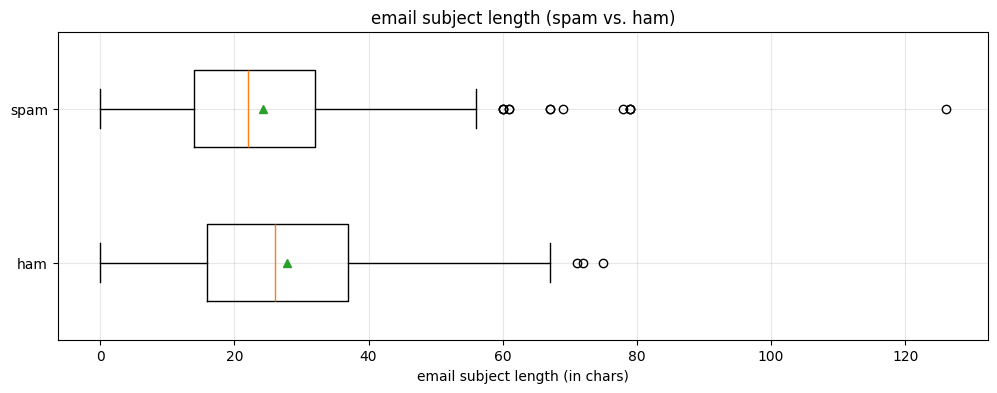

In [7]:
# analyze subject character length 

spam_sublen = all_emails[all_emails['is_spam'] == 1]['subj_len']
ham_sublen = all_emails[all_emails['is_spam'] == 0]['subj_len']

plt.figure(figsize=(12, 4))
plt.boxplot([ham_sublen, spam_sublen], tick_labels=['ham', 'spam'], widths=.5, vert=False, showmeans=True)
plt.xlabel('email subject length (in chars)')
plt.title('email subject length (spam vs. ham)')
plt.grid(True, alpha=0.3)
plt.show()

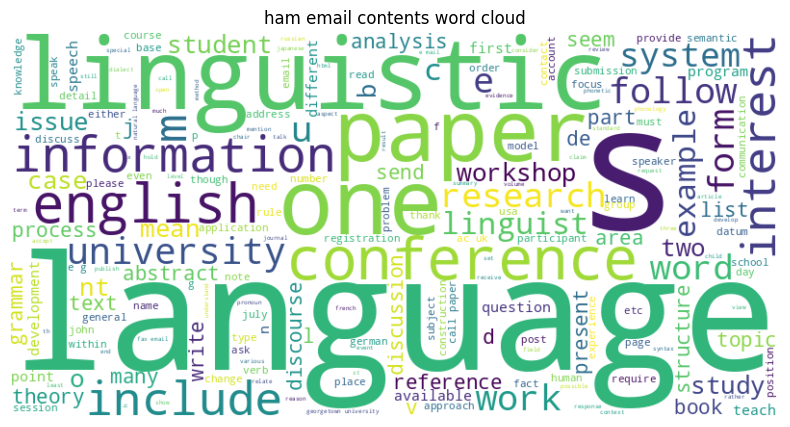

In [8]:
# make word cloud for ham email bodies

text = ' '.join(all_emails[all_emails['is_spam'] == 0]['contents'].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('ham email contents word cloud')
plt.show()

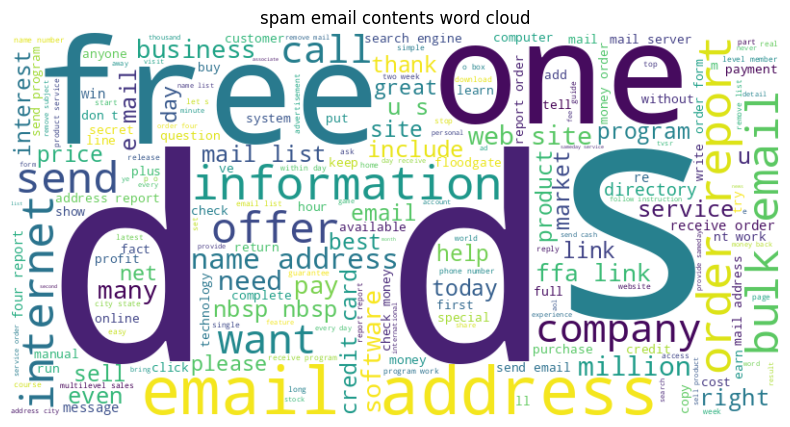

In [9]:
# word cloud for spam email bodies

text = ' '.join(all_emails[all_emails['is_spam'] == 1]['contents'].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('spam email contents word cloud')
plt.show()

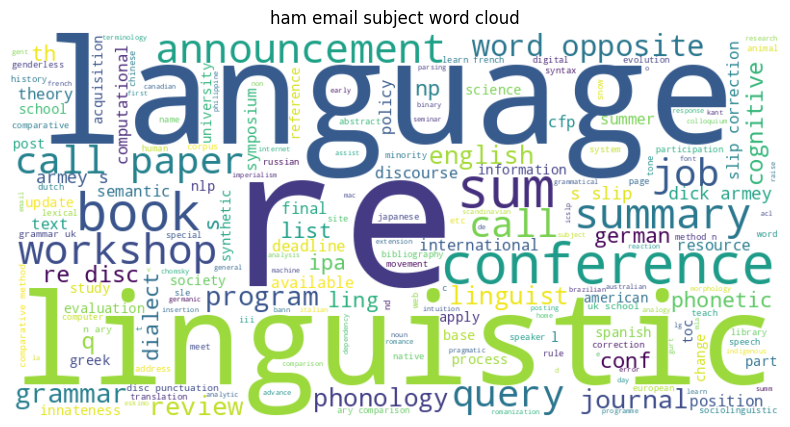

In [10]:
# word cloud for ham email subject lines

text = ' '.join(all_emails[all_emails['is_spam'] == 0]['subject'].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('ham email subject word cloud')
plt.show()

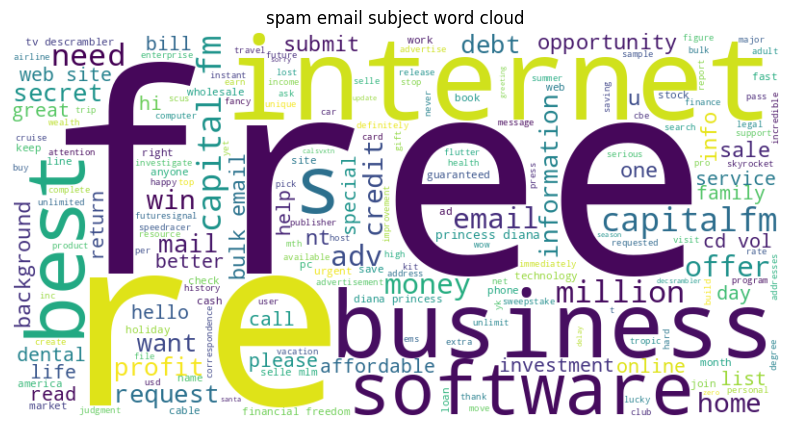

In [11]:
# word cloud for spam email subject lines

text = ' '.join(all_emails[all_emails['is_spam'] == 1]['subject'].astype(str).tolist())
text = re.sub(r'[^A-Za-z\s]', '', text)
stopwords = set(STOPWORDS)
text = ' '.join(word for word in text.split() if word not in stopwords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('spam email subject word cloud')
plt.show()

In [12]:
all_emails['avg_word_len'] = ((all_emails['body_len'] - (all_emails['word_count'] - 1)) / all_emails['word_count']).round(2)
all_emails.head()

all_emails.to_csv('all_emails.csv', index=False)

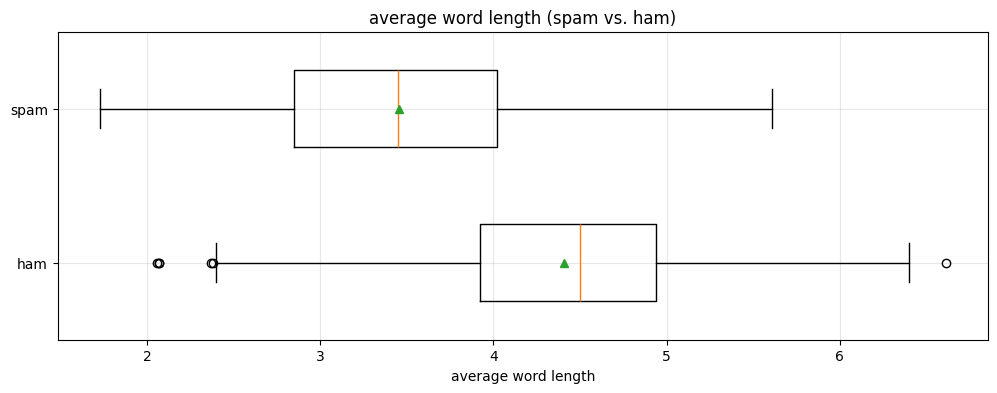

In [13]:
# analyze average word lengths of spam vs. ham

spam_lens = all_emails[all_emails['is_spam'] == 1]['avg_word_len']
ham_lens = all_emails[all_emails['is_spam'] == 0]['avg_word_len'] 

plt.figure(figsize=(12, 4))
plt.boxplot([ham_lens, spam_lens], tick_labels=['ham', 'spam'], widths=.5, vert=False, showmeans=True)
plt.xlabel('average word length')
plt.title('average word length (spam vs. ham)')
plt.grid(True, alpha=0.3)
plt.show()

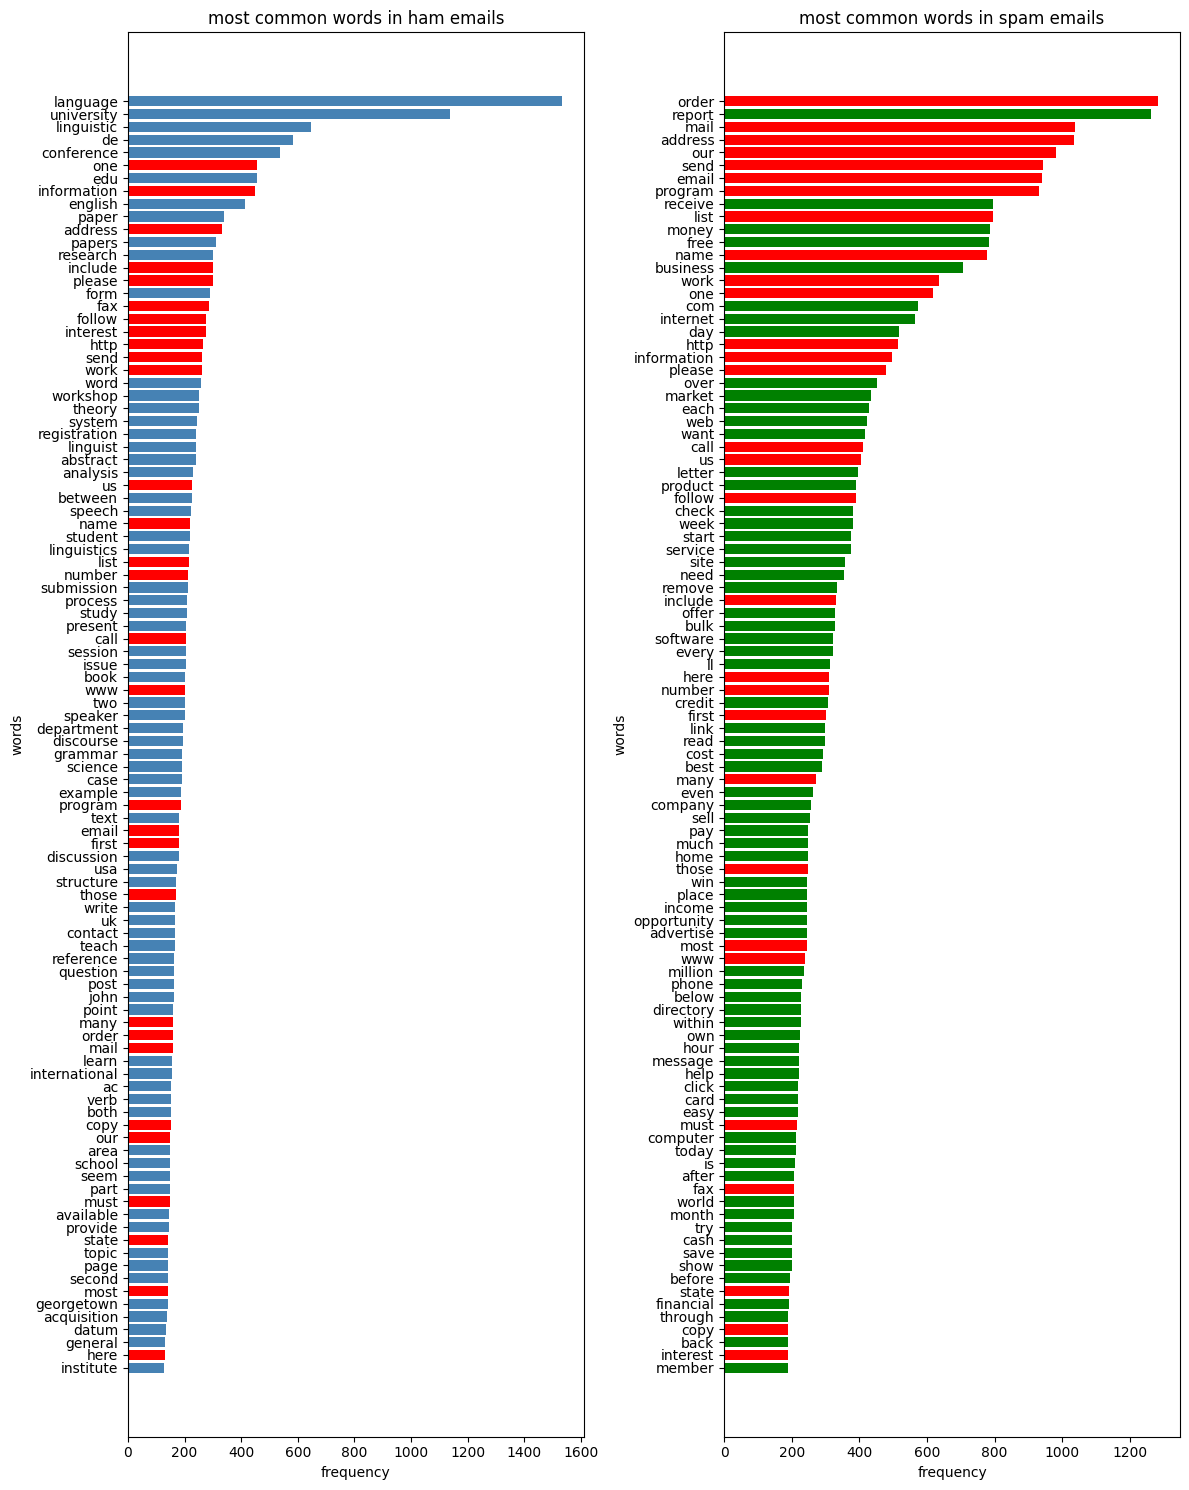

common words: ['address', 'call', 'copy', 'email', 'fax', 'first', 'follow', 'here', 'http', 'include', 'information', 'interest', 'list', 'mail', 'many', 'most', 'must', 'name', 'number', 'one', 'order', 'our', 'please', 'program', 'send', 'state', 'those', 'us', 'work', 'www']


In [14]:
import matplotlib.pyplot as plt

top_count = 100
plt.figure(figsize=(12, 15))

# filter out ham emails 
ham_emails = all_emails[all_emails['is_spam'] == 0]
text = ' '.join(ham_emails['contents'].tolist())
words = text.lower().split()
words = [word for word in words if word.isalpha() and len(word) > 1]

# sort ham email words
ham_wcs = {}
for word in words:
    if word in ham_wcs: ham_wcs[word] += 1
    else: ham_wcs[word] = 1

sorted_words = sorted(ham_wcs.items(), key=lambda x: x[1], reverse=True)
top_ham_words = sorted_words[:top_count]
ham_words = [word for word, count in top_ham_words] 
ham_counts = [count for word, count in top_ham_words]

# filter out spam emails 
spam_emails = all_emails[all_emails['is_spam'] == 1]
text = ' '.join(spam_emails['contents'].tolist())
words = text.lower().split()
words = [word for word in words if word.isalpha() and len(word) > 1]

# sort spam email words
spam_wcs = {}
for word in words:
    if word in spam_wcs: spam_wcs[word] += 1
    else: spam_wcs[word] = 1

sorted_words = sorted(spam_wcs.items(), key=lambda x: x[1], reverse=True)
top_spam_words = sorted_words[:top_count]
spam_words = [word for word, count in top_spam_words] 
spam_counts = [count for word, count in top_spam_words]

# check for common words
common_words = set(ham_words) & set(spam_words)

plt.subplot(1, 2, 1)
colors = ['red' if word in common_words else 'steelblue' for word in ham_words]
plt.barh(ham_words, ham_counts, color=colors)
plt.xlabel('frequency')
plt.ylabel('words')
plt.title('most common words in ham emails')
plt.gca().invert_yaxis()

plt.subplot(1, 2, 2)
colors = ['red' if word in common_words else 'green' for word in spam_words]
plt.barh(spam_words, spam_counts, color=colors)
plt.xlabel('frequency')
plt.ylabel('words')
plt.title('most common words in spam emails')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()

print(f"common words: {sorted(common_words)}")

In [15]:
ham_wcs = sorted(ham_wcs.items(), key=lambda x: x[1], reverse=True)[:100]
print(ham_wcs)
spam_wcs = sorted(spam_wcs.items(), key=lambda x: x[1], reverse=True)[:100]
print(spam_wcs)

[('language', 1533), ('university', 1138), ('linguistic', 645), ('de', 583), ('conference', 538), ('one', 457), ('edu', 455), ('information', 449), ('english', 414), ('paper', 339), ('address', 332), ('papers', 310), ('research', 302), ('include', 300), ('please', 300), ('form', 291), ('fax', 285), ('follow', 277), ('interest', 275), ('http', 266), ('send', 263), ('work', 262), ('word', 257), ('workshop', 252), ('theory', 250), ('system', 244), ('registration', 241), ('linguist', 240), ('abstract', 240), ('analysis', 230), ('us', 228), ('between', 228), ('speech', 223), ('name', 221), ('student', 221), ('linguistics', 215), ('list', 214), ('number', 211), ('submission', 211), ('process', 210), ('study', 207), ('present', 206), ('call', 206), ('session', 205), ('issue', 205), ('book', 203), ('www', 203), ('two', 201), ('speaker', 200), ('department', 195), ('discourse', 194), ('grammar', 192), ('science', 191), ('case', 191), ('example', 189), ('program', 186), ('text', 182), ('email', 

In [16]:
def count_common_words(content, word_list):
    content_words = content.split()
    total = 0
    for word in content_words: 
        if word in word_list: total += 1
    return total 

In [17]:
print(all_emails.columns)

Index(['subject', 'contents', 'subj_len', 'body_len', 'is_spam', 'word_count',
       'avg_word_len'],
      dtype='object')


# !!! USE FAISS AND SENTENCE TRANSFORMER LIBRARIES !!! 

In [18]:
all_emails['ham_wc'] = all_emails['contents'].apply(count_common_words, args=(ham_words,))
all_emails['spam_wc'] = all_emails['contents'].apply(count_common_words, args=(spam_words,))

all_emails.to_csv('all_emails.csv', index=False)
all_emails.head()

,subject,contents,subj_len,body_len,is_spam,word_count,avg_word_len,ham_wc,spam_wc
0,wkshp : * early * - e ( = ) uralic interaction,organize combination colloquium work seminar p...,46,1917,0,340,4.64,26,21
1,job announcement - academium sinica,"job announcement institute history philology ,...",35,1339,0,223,5.01,31,15
2,knowledge language bibliography,association language awareness knowledge langu...,31,953,0,253,2.77,27,9
3,service update,due significant rapid policy change recently i...,14,311,1,54,4.78,8,15
4,job announcement,job announcement department foreign language l...,16,1218,0,204,4.98,26,15


# 4. Prepare the Data


Apply any data transformations and explain what and why

In [19]:
all_emails['full_text'] = all_emails['subject'] + '\n' + all_emails['contents'] 

model = SentenceTransformer('all-MiniLM-L6-v2') 
embeddings = model.encode(all_emails['full_text'].tolist(),
                          show_progress_bar=True, 
                          batch_size=32)

print(f'embeddings shape: {embeddings.shape}')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

embeddings shape: (872, 384)


In [22]:
feats = all_emails[['subj_len', 'body_len', 'word_count', 
                    'avg_word_len', 'ham_wc', 'spam_wc']].values

In [28]:
scaler = StandardScaler()
feats = scaler.fit_transform(feats)

X = np.concatenate([embeddings, feats], axis=1)
y = all_emails['is_spam'].values

# printing shapes to double check
print(f'features shape: {feats.shape}')
print(f'combined feats + embeddings shape: {X.shape}')

features shape: (872, 6)
combined feats + embeddings shape: (872, 390)


In [29]:
# first split off into temp X and y, and leave X_test and y_test as is
X, X_test, y, y_test = train_test_split(X, y, test_size=0.15,
                                        random_state=42,
                                        stratify=y)

# split further to get val sets. 85/15 = 0.176 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.176,
                                                  random_state=42,
                                                  stratify=y)

# double checking 
print(f'train set has {X_train.shape[0]} samples')
print(f'val set has {X_val.shape[0]} samples')
print(f'test set has {X_test.shape[0]} samples')

train set has 610 samples
val set has 131 samples
test set has 131 samples


# 5. Model the data
Using selected ML models, experment with your choices and describe your findings. Finish by selecting a Model to continue with


In [ ]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)

X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_test).reshape(-1, 1)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

train = 

# 6. Fine Tune the Model

With the select model descibe the steps taken to acheve the best rusults possiable 


# 7. Present
In a customer faceing Document provide summery of finding and detail approach taken


# 8. Launch the Model System
Define your production run code, This should be self susficent and require only your model pramaters 
